### Modules

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from HodaDatasetReader import read_hoda_dataset
from sklearn.linear_model import BayesianRidge
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import tensorflow.keras.metrics as tkm
import tensorflow.keras.layers as tkl
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import tensorflow as tf
import numpy as np
import time
import cv2
import os

### Dataset Preparation

In [ ]:
X, Y = read_hoda_dataset(dataset_path='/content/Train 60000.cdb',
                                     images_height=28,
                                     images_width=28,
                                     one_hot=False,
                                     reshape=False)

In [ ]:
def dataset(X, Y):
  x_train, y_train = X[12000:], Y[12000:]
  x_test, y_test = X[:12000], Y[:12000]
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return x_train, x_test, y_train, y_test

## Visualization

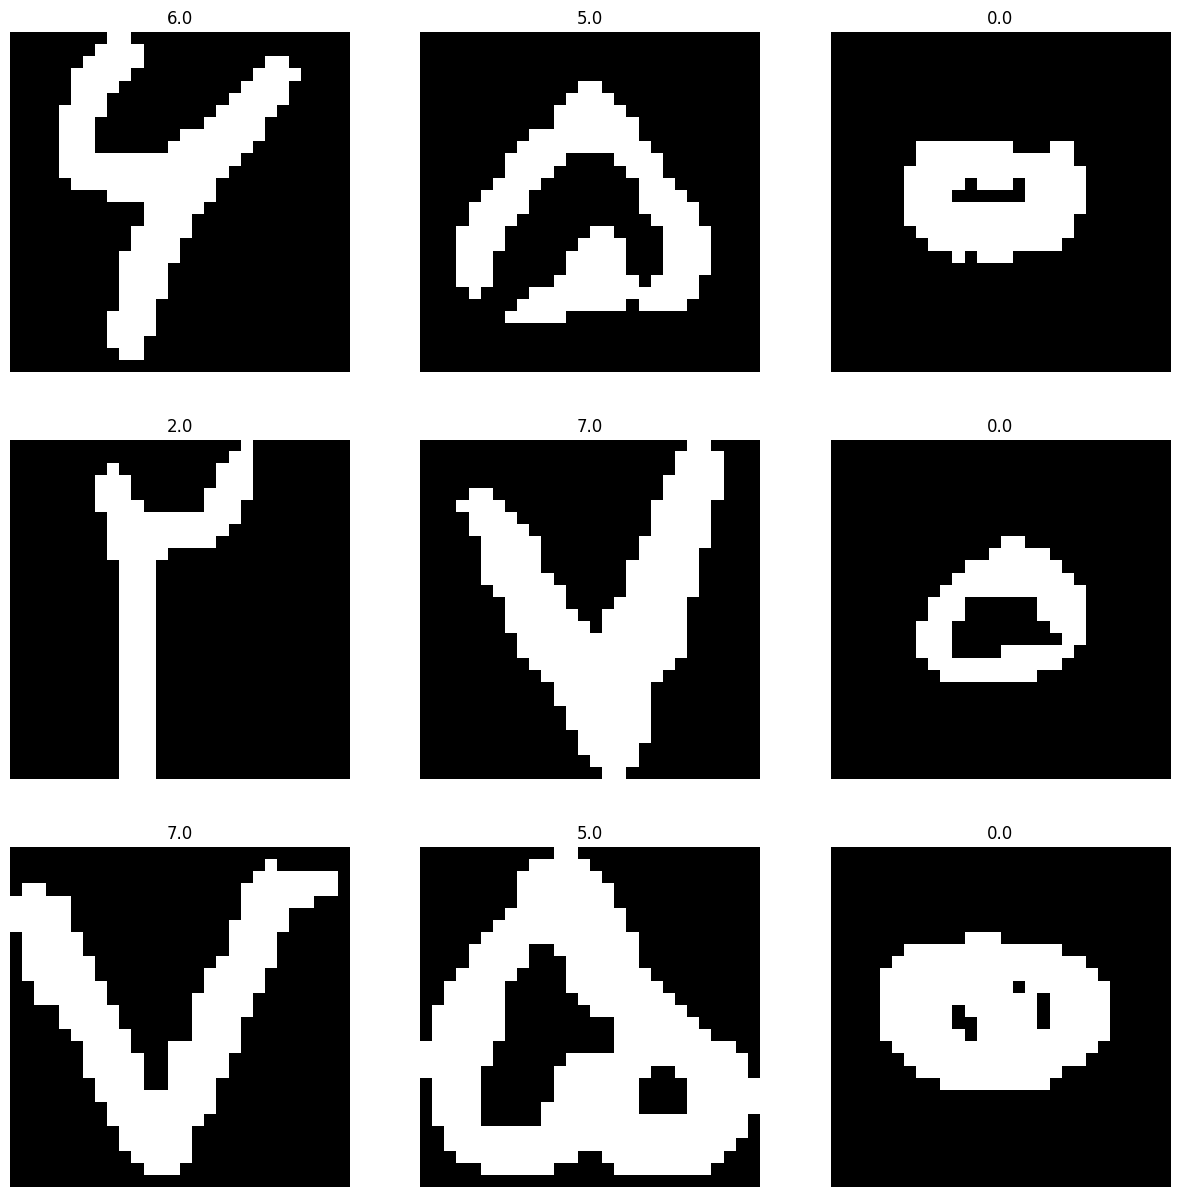

In [ ]:
plt.figure(figsize=(15,15))
for i in range (9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(X[i], cmap='gray')
  plt.title(Y[i])
  plt.axis('off')

## Model

In [ ]:
WIDTH = 28
HEIGHT = 28
n_channels = 1

In [ ]:
input_size = (WIDTH, HEIGHT, n_channels)


input_img = tf.keras.Input(input_size, name = 'image')
conv0 = tkl.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal')(input_img)
conv1 = tkl.Activation('relu')(conv0)


pool0 = tkl.MaxPooling2D((2,2))(conv1)
conv2 = tkl.Dropout(0.1)(pool0)

conv3 = tkl.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv4 = tkl.Activation('relu')(conv3)

pool1 = tkl.MaxPooling2D((2,2))(conv4)
conv5 = tkl.Dropout(0.1)(pool1)

flat = tkl.Flatten()(conv5)
dense1 = tkl.Dense(64, activation='relu')(flat)
output = tkl.Dense(10, activation = 'softmax')(dense1)

model = tf.keras.Model(inputs = [input_img], outputs = [output])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 activation (Activation)     (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                             

In [ ]:
adam = Adam(learning_rate = 0.003)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics = [tkm.Recall(), tkm.Precision(), 'accuracy'])

## Holdout

In [ ]:
x_train, x_test, y_train, y_test = dataset(X, Y)
print(f'x_train shape is: {x_train.shape}')
print(f'x_test shape is: {x_test.shape}')
print(f'y_train shape is: {y_train.shape}')

x_train shape is: (48000, 28, 28, 1)
x_test shape is: (12000, 28, 28, 1)
y_train shape is: (48000, 10)


In [ ]:
holdout_stime = time.time()
history = model.fit(x_train, y_train,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=10)

holdout_etime = time.time()
holdout_runtime = holdout_etime - holdout_stime

Epoch 1/10
1500/1500 [==============================] - 19s 5ms/step - loss: 0.0868 - recall: 0.9709 - precision: 0.9794 - accuracy: 0.9741
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0300 - recall: 0.9902 - precision: 0.9917 - accuracy: 0.9907
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0225 - recall: 0.9931 - precision: 0.9937 - accuracy: 0.9933
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0167 - recall: 0.9946 - precision: 0.9951 - accuracy: 0.9950
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0155 - recall: 0.9952 - precision: 0.9956 - accuracy: 0.9953
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0132 - recall: 0.9959 - precision: 0.9964 - accuracy: 0.9961
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0116 - recall: 0.9965 - precision: 0.9969 - accuracy: 0.9966
Epoch 8/10
1500/1500 [====

### Evaluation:

In [ ]:
cnn_eval_hist = model.evaluate(x_test, y_test)

375/375 [==============================] - 1s 3ms/step - loss: 0.0405 - recall: 0.9918 - precision: 0.9920 - accuracy: 0.9918


In [ ]:
print(f'Training time: {holdout_runtime} seconds')
cnn_eval_accuracy = cnn_eval_hist[3]
cnn_eval_precision = cnn_eval_hist[2]
cnn_eval_recall = cnn_eval_hist[1]
print(f'accuracy is:{cnn_eval_accuracy} \nrecall is:{cnn_eval_recall} \nprecision is:{cnn_eval_precision}')
f1_score_test = 2 * (cnn_eval_precision * cnn_eval_recall) / (cnn_eval_precision +cnn_eval_recall)
print(f'f1 score is: {f1_score_test}')

Training time: 83.87016534805298 seconds
accuracy is:0.9917500019073486 
recall is:0.9917500019073486 
precision is:0.991998016834259
f1 score is: 0.9918739938669688


In [ ]:
model.save('PersianHandwritten.h5')

## Cross K Fold Validation (K=3)

In [ ]:
training_times = list()
n_split=3
eval_histories = list()
stime = time.time()
for train_index, test_index in KFold(n_split).split(X):
  x_train, x_test = X[train_index],X[test_index]
  y_train, y_test = Y[train_index],Y[test_index]
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  fold_stime = time.time()

  history = model.fit(x_train, y_train,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=10)
  fold_etime = time.time()
  eval_hist = model.evaluate(x_test, y_test)
  eval_histories.append(eval_hist)
  print('Model evaluation ',eval_hist)

  fold_runtime = fold_etime - fold_stime
  training_times.append(fold_runtime)

etime = time.time()
thorough_runtime = etime - stime

Epoch 1/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0095 - recall: 0.9972 - precision: 0.9973 - accuracy: 0.9973
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0085 - recall: 0.9974 - precision: 0.9974 - accuracy: 0.9974
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0091 - recall: 0.9974 - precision: 0.9976 - accuracy: 0.9975
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0094 - recall: 0.9979 - precision: 0.9979 - accuracy: 0.9979
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0065 - recall: 0.9981 - precision: 0.9982 - accuracy: 0.9981
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0075 - recall: 0.9978 - precision: 0.9978 - accuracy: 0.9978
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0063 - recall: 0.9983 - precision: 0.9983 - accuracy: 0.9983
Epoch 8/10
1250/1250 [=====

### Evaluation:

In [ ]:
ord_nums = ['first', 'second', 'third']
sum_precision = sum_recall = 0
for eval_hist in eval_histories:
  sum_recall += eval_hist[2]
  sum_precision += eval_hist[3]

recall_ave = sum_recall / n_split
precision_ave = sum_precision / n_split
f1_score_ave = 2 * (precision_ave * recall_ave) / (precision_ave + recall_ave)
print(f'The average of precisions is: {precision_ave}')
print(f'The average of recalls is: {recall_ave}')
print(f'Cross validation f1_score is: {f1_score_ave}')

The average of precisions is: 0.9977166652679443
The average of recalls is: 0.9977332552274069
Cross validation f1_score is: 0.9977249601787119


In [ ]:
i = 0
for time in training_times:
  print(f'The {ord_nums[i]} fold took {time} seconds.')
  i += 1

print(f'Process took {thorough_runtime} seconds to complete.')

The first fold took 55.06460738182068 seconds.
The second fold took 53.394662618637085 seconds.
The third fold took 53.98071765899658 seconds.
Process took 169.0479702949524 seconds to complete.


## Comparing the CNN model with a SVM model, a KNN model and a Bayesian model based on accuracies:

In [ ]:
x_train, y_train = X[12000:], Y[12000:]
x_test, y_test = X[:12000], Y[:12000]

In [ ]:
h, w, d = x_train.shape[1], x_train.shape[2], x_train.shape[3]
x_train_reshaped = x_train.reshape(x_train.shape[0], h*w*d)

In [ ]:
x_train_reshaped.shape

(48000, 784)

In [ ]:
h, w, d = x_test.shape[1], x_test.shape[2], x_test.shape[3]
x_test_reshaped = x_test.reshape(x_test.shape[0], h*w*d)

In [ ]:
x_test_reshaped.shape

(12000, 784)

### SVM

In [ ]:
svm_clf = SVC().fit(x_train_reshaped, y_train)

In [ ]:
svm_eval = svm_clf.score(x_test_reshaped, y_test)
svm_eval

0.9860833333333333

### KNN

In [ ]:
neigh_clf = KNeighborsClassifier().fit(x_train_reshaped, y_train)

In [ ]:
knn_eval = neigh_clf.score(x_test_reshaped, y_test)
knn_eval

0.9766666666666667

### Bayesian Ridge

In [ ]:
bayes_clf = BayesianRidge().fit(x_train_reshaped, y_train)

In [ ]:
bayes_eval = bayes_clf.score(x_test_reshaped, y_test)
bayes_eval

0.7258763813684341

### Bar plot shows the difference between accuracies:

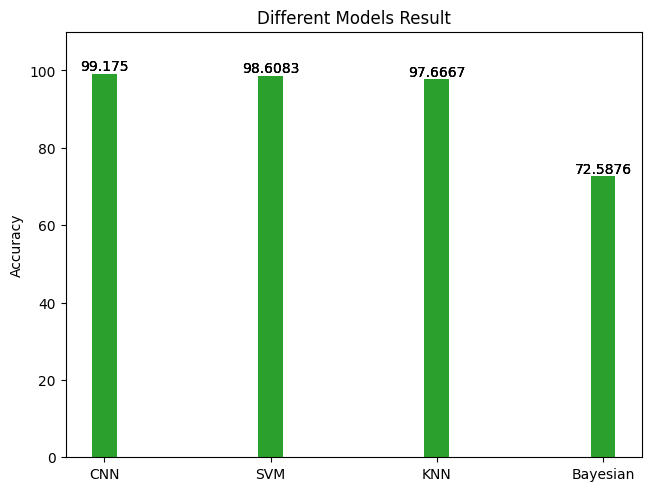

In [ ]:
models = ("CNN", "SVM", "KNN", "Bayesian")
accuracies = [cnn_eval_hist[3]*100, svm_eval*100, knn_eval*100, bayes_eval *100]

x = np.arange(len(models))  # the label locations
width = 0.15
fig, ax = plt.subplots(layout='constrained')

for i in range(3):
    offset = width
    rects = ax.bar(x + offset, accuracies, width, label=models)
    ax.bar_label(rects)

ax.set_ylabel('Accuracy')
ax.set_title('Different Models Result')
ax.set_xticks(x + width, models)
ax.set_ylim(0, 110)

plt.show()

### Testing the CNN model with my handwritten digits:

In [ ]:
!unzip /content/digits.zip

Archive:  /content/digits.zip
  inflating: digits/0.png            
  inflating: digits/1.png            
  inflating: digits/2.png            
  inflating: digits/3.png            
  inflating: digits/4.png            
  inflating: digits/5.png            
  inflating: digits/6.png            
  inflating: digits/7.png            
  inflating: digits/8.png            
  inflating: digits/9.png            


1/1 [==============================] - 0s 211ms/step
This digit is probably a 0


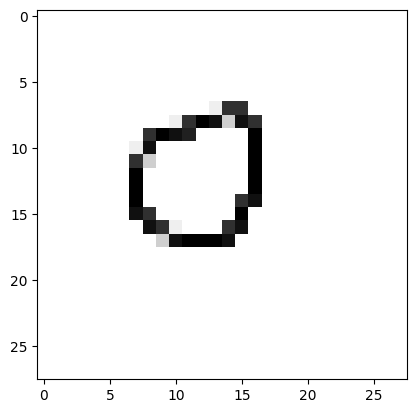

1/1 [==============================] - 0s 34ms/step
This digit is probably a 1


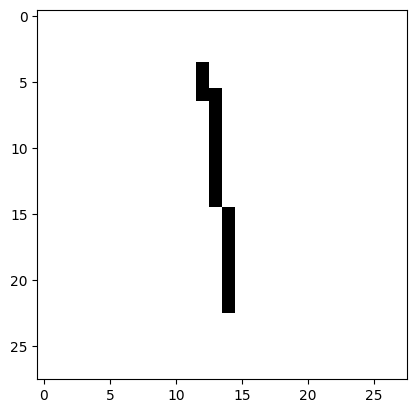

1/1 [==============================] - 0s 29ms/step
This digit is probably a 2


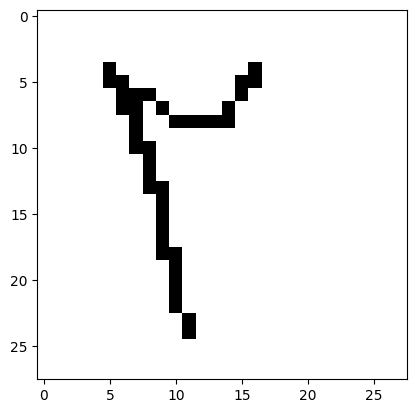

1/1 [==============================] - 0s 29ms/step
This digit is probably a 3


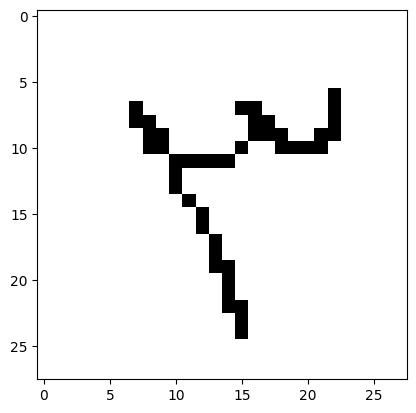

1/1 [==============================] - 0s 28ms/step
This digit is probably a 4


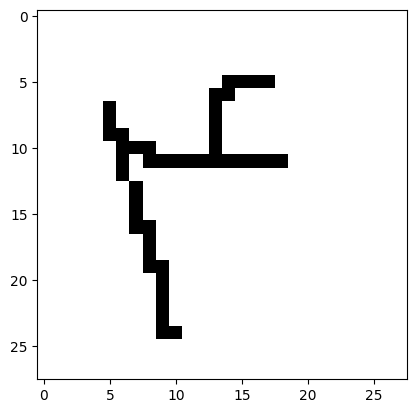

1/1 [==============================] - 0s 30ms/step
This digit is probably a 5


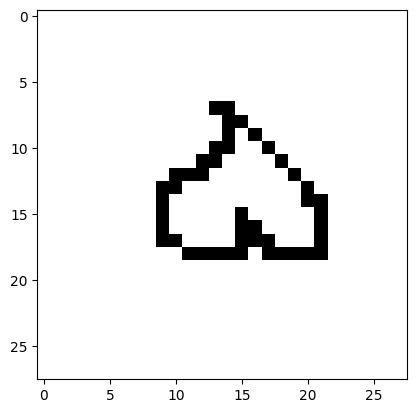

1/1 [==============================] - 0s 27ms/step
This digit is probably a 6


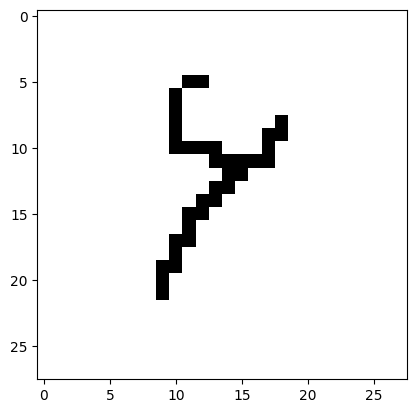

1/1 [==============================] - 0s 18ms/step
This digit is probably a 7


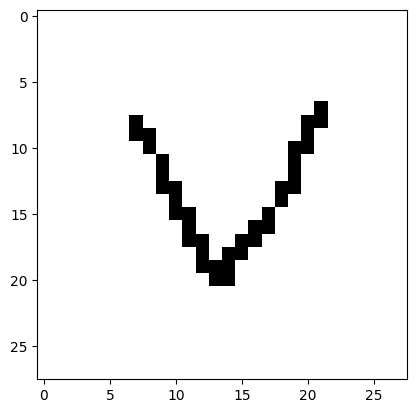

1/1 [==============================] - 0s 19ms/step
This digit is probably a 8


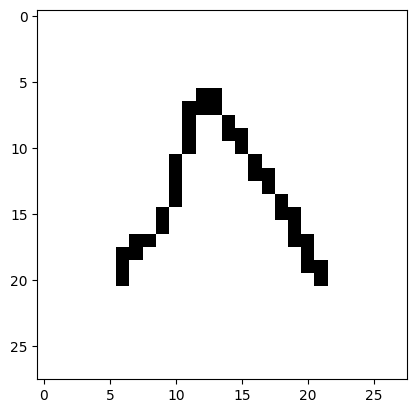

1/1 [==============================] - 0s 18ms/step
This digit is probably a 9


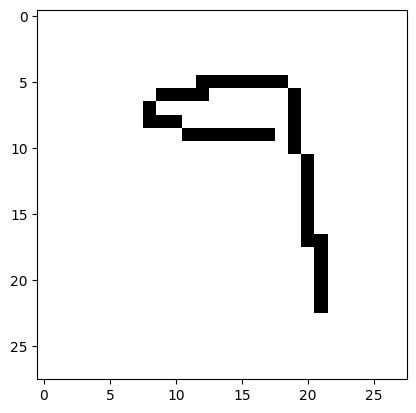

In [ ]:
image_number = 0
while os.path.isfile(f"/content/digits/{image_number}.png"):
  try:
    img = cv2.imread(f"/content/digits/{image_number}.png")[:,:,0]
    img = np.invert(np.array([img]))
    prediction = model.predict(img)
    print(f"This digit is probably a {np.argmax(prediction)}")
    plt.imshow(img[0], cmap=plt.cm.binary)
    plt.show()
  except:
    print("Error")
  finally:
    image_number += 1